from https://keras.io/examples/generative/wgan_gp/

# 데이터 준비

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [ ]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

noise_dim = 128
NORMAL_NUMMBER = 8

In [ ]:
dataset = keras.datasets.mnist

(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = dataset.load_data()
images = raw_train_x.reshape(len(raw_train_x), 28, 28, 1).astype("float32")
images = (images - 127.5) / 127.5

normal_image_indexes = np.where(raw_train_y==NORMAL_NUMMBER)
train_images = images[normal_image_indexes]
print(f"Number of examples: {len(train_images)}")



Number of examples: 5851


# D 정의

In [ ]:
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)
    # 28x28 영상을 32x32로 만드릭 위해 padding 한다.
    x = ZeroPadding2D((2, 2))(img_input)
    x = conv_block(x,  64, (5, 5), use_dropout=False)
    x = conv_block(x, 128, (5, 5), use_dropout=True)
    x = conv_block(x, 256, (5, 5), use_dropout=True)
    x = conv_block(x, 512, (5, 5), use_dropout=False)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 32, 32, 1)   0           ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 16, 16, 64)   1664        ['zero_padding2d_2[0][0]']       
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      multiple             0           ['conv2d_14[0][0]',  

# G 정의


In [ ]:

def upsample_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bn=True,
    use_bias=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((4, 4, 256))(x)
    x = upsample_block(x, 128, )
    x = upsample_block(x,  64, )
    x = upsample_block(x,   1, activation=Activation("tanh"))
    # 생성된 이미지 32x32를 28x28로 만들기 위해 cropping한다.
    x = Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 4096)         524288      ['input_6[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 4096)        16384       ['dense_5[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 4096)         0           ['batch_normalization_8[0

# WGAN-GP 모델 정의

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # D 학습

        # D는 G에 비해 d_steps 배 학습함.
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # G 학습
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 에폭 마다 결과 보는 callback

In [ ]:
import matplotlib.pyplot as plt

class GANMonitor(Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        print("epoch",epoch)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        plt.figure(figsize=(10, 3))
        for i in range(1, self.num_img):
            ax = plt.subplot(1, self.num_img, i)
            plt.imshow(generated_images[i-1].numpy().squeeze(), cmap="binary")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

        # for i in range(self.num_img):
        #     img = generated_images[i].numpy()
        #     img = keras.preprocessing.image.array_to_img(img)
        #     img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))



# 학습


Epoch 1/100
12/12 [==============================] - ETA: 0s - d_loss: -18.9050 - g_loss: -6.5356epoch 0


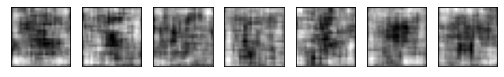

12/12 [==============================] - 10s 365ms/step - d_loss: -19.0900 - g_loss: -7.2472
Epoch 2/100
12/12 [==============================] - ETA: 0s - d_loss: -18.1368 - g_loss: -18.7191epoch 1


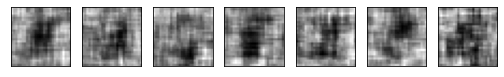

12/12 [==============================] - 4s 334ms/step - d_loss: -18.0625 - g_loss: -19.0228
Epoch 3/100
12/12 [==============================] - ETA: 0s - d_loss: -16.5803 - g_loss: -22.4838epoch 2


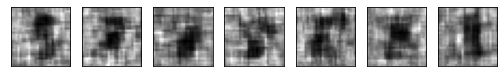

12/12 [==============================] - 4s 335ms/step - d_loss: -16.5244 - g_loss: -22.4920
Epoch 4/100
12/12 [==============================] - ETA: 0s - d_loss: -16.0318 - g_loss: -23.2902epoch 3


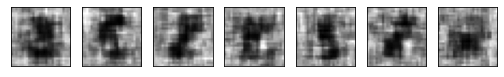

12/12 [==============================] - 4s 335ms/step - d_loss: -16.0077 - g_loss: -23.3060
Epoch 5/100
12/12 [==============================] - ETA: 0s - d_loss: -15.5070 - g_loss: -23.4061epoch 4


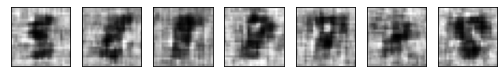

12/12 [==============================] - 4s 333ms/step - d_loss: -15.4893 - g_loss: -23.4885
Epoch 6/100
12/12 [==============================] - ETA: 0s - d_loss: -15.0385 - g_loss: -22.6944epoch 5


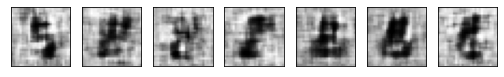

12/12 [==============================] - 4s 338ms/step - d_loss: -15.0388 - g_loss: -22.7756
Epoch 7/100
12/12 [==============================] - ETA: 0s - d_loss: -15.0027 - g_loss: -20.3538epoch 6


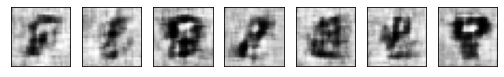

12/12 [==============================] - 4s 359ms/step - d_loss: -15.0042 - g_loss: -20.1635
Epoch 8/100
12/12 [==============================] - ETA: 0s - d_loss: -15.2690 - g_loss: -17.6905epoch 7


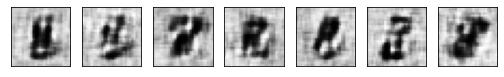

12/12 [==============================] - 4s 335ms/step - d_loss: -15.2321 - g_loss: -17.4165
Epoch 9/100
12/12 [==============================] - ETA: 0s - d_loss: -15.0888 - g_loss: -13.0575epoch 8


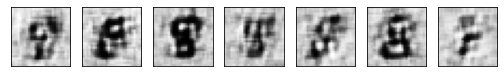

12/12 [==============================] - 4s 334ms/step - d_loss: -15.0808 - g_loss: -12.8308
Epoch 10/100
12/12 [==============================] - ETA: 0s - d_loss: -15.1748 - g_loss: -11.1834epoch 9


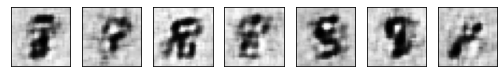

12/12 [==============================] - 4s 337ms/step - d_loss: -15.1462 - g_loss: -11.1510
Epoch 11/100
12/12 [==============================] - ETA: 0s - d_loss: -14.7724 - g_loss: -10.7740epoch 10


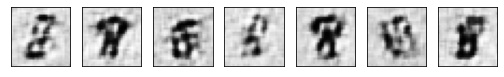

12/12 [==============================] - 4s 336ms/step - d_loss: -14.8096 - g_loss: -10.8180
Epoch 12/100
12/12 [==============================] - ETA: 0s - d_loss: -14.7724 - g_loss: -10.8932epoch 11


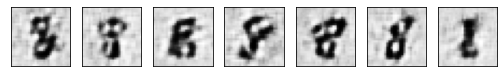

12/12 [==============================] - 4s 335ms/step - d_loss: -14.7818 - g_loss: -11.0628
Epoch 13/100
12/12 [==============================] - ETA: 0s - d_loss: -14.2943 - g_loss: -10.7259epoch 12


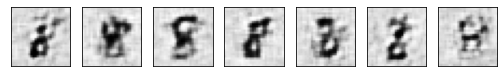

12/12 [==============================] - 4s 336ms/step - d_loss: -14.3269 - g_loss: -10.8949
Epoch 14/100
12/12 [==============================] - ETA: 0s - d_loss: -14.1194 - g_loss: -10.0945epoch 13


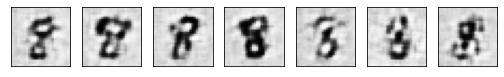

12/12 [==============================] - 4s 340ms/step - d_loss: -14.1567 - g_loss: -10.0238
Epoch 15/100
12/12 [==============================] - ETA: 0s - d_loss: -14.0231 - g_loss: -11.1591epoch 14


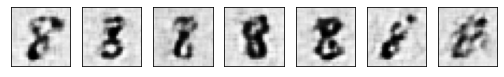

12/12 [==============================] - 4s 334ms/step - d_loss: -14.0306 - g_loss: -11.3809
Epoch 16/100
12/12 [==============================] - ETA: 0s - d_loss: -13.6965 - g_loss: -10.5304epoch 15


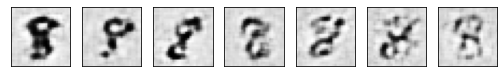

12/12 [==============================] - 4s 336ms/step - d_loss: -13.7709 - g_loss: -10.5126
Epoch 17/100
12/12 [==============================] - ETA: 0s - d_loss: -13.4949 - g_loss: -10.2481epoch 16


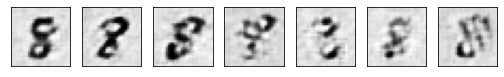

12/12 [==============================] - 4s 365ms/step - d_loss: -13.5017 - g_loss: -10.3020
Epoch 18/100
12/12 [==============================] - ETA: 0s - d_loss: -13.3925 - g_loss: -8.3036epoch 17


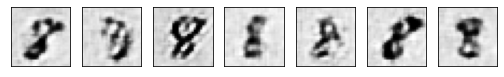

12/12 [==============================] - 4s 334ms/step - d_loss: -13.3203 - g_loss: -8.3304
Epoch 19/100
12/12 [==============================] - ETA: 0s - d_loss: -12.9980 - g_loss: -8.1911epoch 18


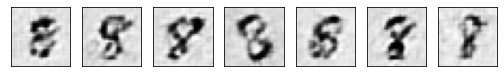

12/12 [==============================] - 4s 337ms/step - d_loss: -13.0547 - g_loss: -8.2079
Epoch 20/100
12/12 [==============================] - ETA: 0s - d_loss: -12.8890 - g_loss: -7.8072epoch 19


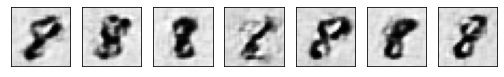

12/12 [==============================] - 4s 337ms/step - d_loss: -12.8781 - g_loss: -7.6414
Epoch 21/100
12/12 [==============================] - ETA: 0s - d_loss: -12.7643 - g_loss: -6.2717epoch 20


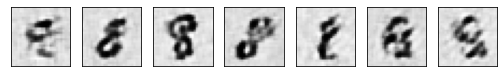

12/12 [==============================] - 4s 336ms/step - d_loss: -12.7021 - g_loss: -6.0343
Epoch 22/100
12/12 [==============================] - ETA: 0s - d_loss: -12.9051 - g_loss: -5.6372epoch 21


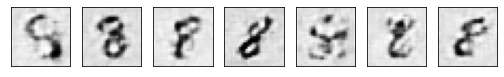

12/12 [==============================] - 4s 335ms/step - d_loss: -12.9464 - g_loss: -5.5814
Epoch 23/100
12/12 [==============================] - ETA: 0s - d_loss: -12.5766 - g_loss: -4.2907epoch 22


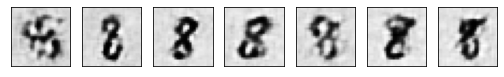

12/12 [==============================] - 4s 334ms/step - d_loss: -12.6091 - g_loss: -4.3147
Epoch 24/100
12/12 [==============================] - ETA: 0s - d_loss: -12.4147 - g_loss: -3.1986epoch 23


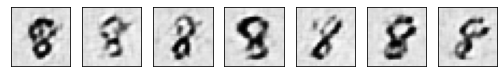

12/12 [==============================] - 4s 334ms/step - d_loss: -12.3800 - g_loss: -3.2692
Epoch 25/100
12/12 [==============================] - ETA: 0s - d_loss: -12.4667 - g_loss: -3.9798epoch 24


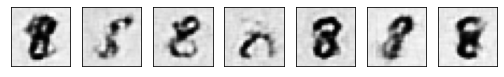

12/12 [==============================] - 4s 336ms/step - d_loss: -12.4482 - g_loss: -4.0787
Epoch 26/100
12/12 [==============================] - ETA: 0s - d_loss: -12.2692 - g_loss: -2.1992epoch 25


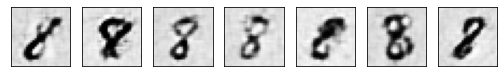

12/12 [==============================] - 4s 335ms/step - d_loss: -12.2581 - g_loss: -2.2572
Epoch 27/100
12/12 [==============================] - ETA: 0s - d_loss: -12.1063 - g_loss: -2.1381epoch 26


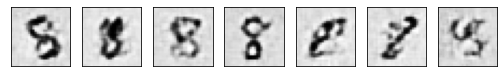

12/12 [==============================] - 4s 335ms/step - d_loss: -12.1139 - g_loss: -2.1871
Epoch 28/100
12/12 [==============================] - ETA: 0s - d_loss: -12.1050 - g_loss: -1.4263epoch 27


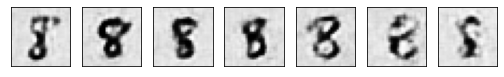

12/12 [==============================] - 4s 364ms/step - d_loss: -12.0638 - g_loss: -1.2518
Epoch 29/100
12/12 [==============================] - ETA: 0s - d_loss: -11.7850 - g_loss: -1.9880epoch 28


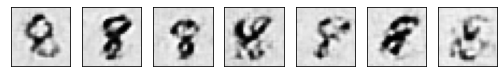

12/12 [==============================] - 4s 334ms/step - d_loss: -11.7434 - g_loss: -1.9117
Epoch 30/100
12/12 [==============================] - ETA: 0s - d_loss: -11.7445 - g_loss: -0.5587epoch 29


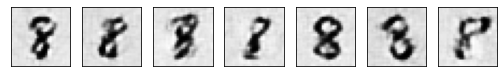

12/12 [==============================] - 4s 336ms/step - d_loss: -11.7124 - g_loss: -0.6080
Epoch 31/100
12/12 [==============================] - ETA: 0s - d_loss: -11.7614 - g_loss: -0.7050epoch 30


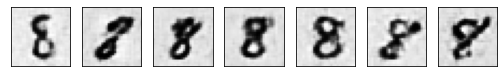

12/12 [==============================] - 4s 335ms/step - d_loss: -11.6791 - g_loss: -0.8556
Epoch 32/100
12/12 [==============================] - ETA: 0s - d_loss: -11.5397 - g_loss: -1.5707epoch 31


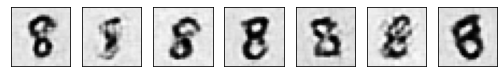

12/12 [==============================] - 4s 336ms/step - d_loss: -11.5452 - g_loss: -1.8104
Epoch 33/100
12/12 [==============================] - ETA: 0s - d_loss: -11.5403 - g_loss: -0.9395epoch 32


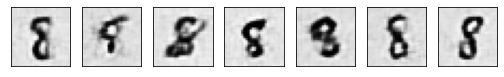

12/12 [==============================] - 4s 337ms/step - d_loss: -11.5361 - g_loss: -0.9158
Epoch 34/100
12/12 [==============================] - ETA: 0s - d_loss: -11.1239 - g_loss: 0.3590epoch 33


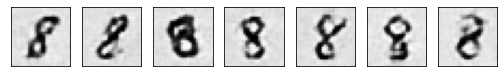

12/12 [==============================] - 4s 337ms/step - d_loss: -11.1329 - g_loss: 0.4169
Epoch 35/100
12/12 [==============================] - ETA: 0s - d_loss: -11.1293 - g_loss: 1.2324epoch 34


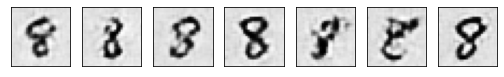

12/12 [==============================] - 4s 335ms/step - d_loss: -11.1230 - g_loss: 1.3279
Epoch 36/100
12/12 [==============================] - ETA: 0s - d_loss: -11.0990 - g_loss: 1.8018epoch 35


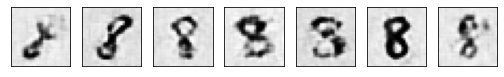

12/12 [==============================] - 4s 336ms/step - d_loss: -11.0556 - g_loss: 1.8592
Epoch 37/100
12/12 [==============================] - ETA: 0s - d_loss: -11.0099 - g_loss: 1.5116epoch 36


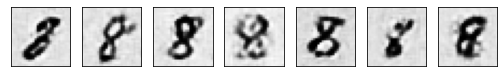

12/12 [==============================] - 4s 335ms/step - d_loss: -11.0200 - g_loss: 1.4578
Epoch 38/100
12/12 [==============================] - ETA: 0s - d_loss: -10.9097 - g_loss: 1.0292epoch 37


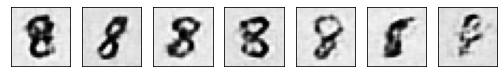

12/12 [==============================] - 4s 336ms/step - d_loss: -10.8641 - g_loss: 1.1389
Epoch 39/100
12/12 [==============================] - ETA: 0s - d_loss: -10.8553 - g_loss: 0.9373epoch 38


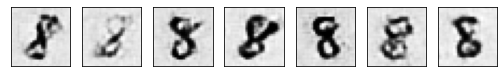

12/12 [==============================] - 4s 367ms/step - d_loss: -10.8343 - g_loss: 0.8642
Epoch 40/100
12/12 [==============================] - ETA: 0s - d_loss: -10.7901 - g_loss: 3.5473epoch 39


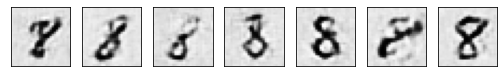

12/12 [==============================] - 4s 341ms/step - d_loss: -10.8087 - g_loss: 3.7487
Epoch 41/100
12/12 [==============================] - ETA: 0s - d_loss: -10.4621 - g_loss: 2.9765epoch 40


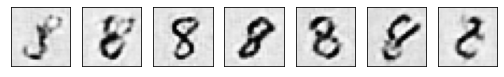

12/12 [==============================] - 4s 338ms/step - d_loss: -10.4463 - g_loss: 2.9666
Epoch 42/100
12/12 [==============================] - ETA: 0s - d_loss: -10.4292 - g_loss: 3.7916epoch 41


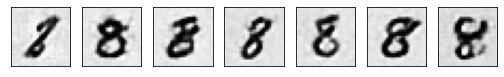

12/12 [==============================] - 4s 335ms/step - d_loss: -10.3839 - g_loss: 4.1227
Epoch 43/100
12/12 [==============================] - ETA: 0s - d_loss: -10.3734 - g_loss: 4.8060epoch 42


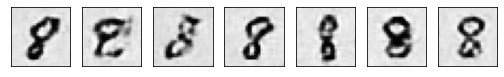

12/12 [==============================] - 4s 335ms/step - d_loss: -10.3554 - g_loss: 4.7002
Epoch 44/100
12/12 [==============================] - ETA: 0s - d_loss: -10.2625 - g_loss: 6.2149epoch 43


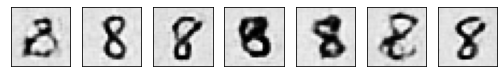

12/12 [==============================] - 4s 337ms/step - d_loss: -10.2621 - g_loss: 6.1997
Epoch 45/100
12/12 [==============================] - ETA: 0s - d_loss: -10.3853 - g_loss: 6.6097epoch 44


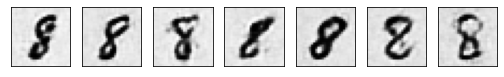

12/12 [==============================] - 4s 338ms/step - d_loss: -10.3531 - g_loss: 6.6378
Epoch 46/100
12/12 [==============================] - ETA: 0s - d_loss: -10.0433 - g_loss: 7.5278epoch 45


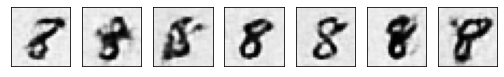

12/12 [==============================] - 4s 339ms/step - d_loss: -9.9813 - g_loss: 7.6446
Epoch 47/100
12/12 [==============================] - ETA: 0s - d_loss: -10.0690 - g_loss: 7.4780epoch 46


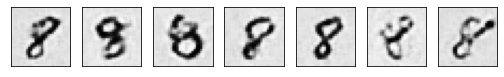

12/12 [==============================] - 4s 338ms/step - d_loss: -10.0759 - g_loss: 7.3971
Epoch 48/100
12/12 [==============================] - ETA: 0s - d_loss: -9.9301 - g_loss: 6.7784 epoch 47


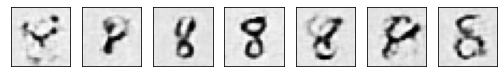

12/12 [==============================] - 4s 337ms/step - d_loss: -9.8640 - g_loss: 7.0336
Epoch 49/100
12/12 [==============================] - ETA: 0s - d_loss: -9.9577 - g_loss: 5.3820epoch 48


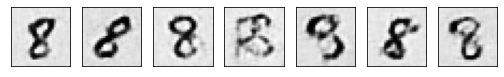

12/12 [==============================] - 4s 339ms/step - d_loss: -9.9493 - g_loss: 5.4043
Epoch 50/100
12/12 [==============================] - ETA: 0s - d_loss: -9.8942 - g_loss: 4.4918epoch 49


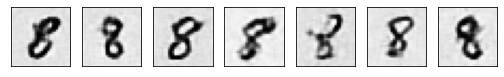

12/12 [==============================] - 4s 367ms/step - d_loss: -9.9356 - g_loss: 4.5520
Epoch 51/100
12/12 [==============================] - ETA: 0s - d_loss: -9.5793 - g_loss: 5.8228epoch 50


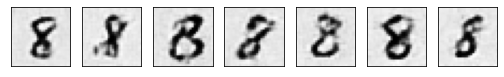

12/12 [==============================] - 4s 337ms/step - d_loss: -9.6183 - g_loss: 5.7218
Epoch 52/100
12/12 [==============================] - ETA: 0s - d_loss: -9.2893 - g_loss: 4.6812epoch 51


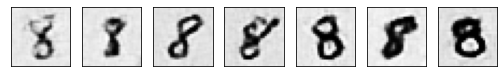

12/12 [==============================] - 4s 338ms/step - d_loss: -9.2984 - g_loss: 4.5170
Epoch 53/100
12/12 [==============================] - ETA: 0s - d_loss: -9.3930 - g_loss: 4.4584epoch 52


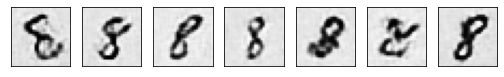

12/12 [==============================] - 4s 334ms/step - d_loss: -9.3509 - g_loss: 4.4844
Epoch 54/100
12/12 [==============================] - ETA: 0s - d_loss: -9.3252 - g_loss: 4.9078epoch 53


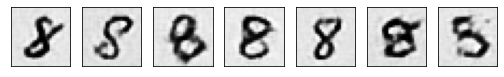

12/12 [==============================] - 4s 337ms/step - d_loss: -9.3105 - g_loss: 4.9694
Epoch 55/100
12/12 [==============================] - ETA: 0s - d_loss: -9.1138 - g_loss: 5.3528epoch 54


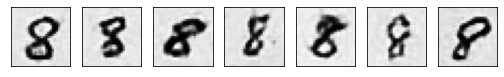

12/12 [==============================] - 4s 336ms/step - d_loss: -9.0822 - g_loss: 5.3398
Epoch 56/100
12/12 [==============================] - ETA: 0s - d_loss: -9.0986 - g_loss: 4.8259epoch 55


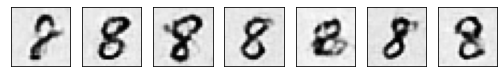

12/12 [==============================] - 4s 336ms/step - d_loss: -9.0825 - g_loss: 4.7760
Epoch 57/100
12/12 [==============================] - ETA: 0s - d_loss: -9.0071 - g_loss: 4.3181epoch 56


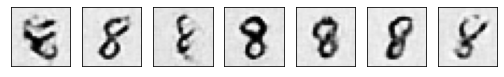

12/12 [==============================] - 4s 337ms/step - d_loss: -8.9911 - g_loss: 4.5547
Epoch 58/100
12/12 [==============================] - ETA: 0s - d_loss: -9.2249 - g_loss: 6.0078epoch 57


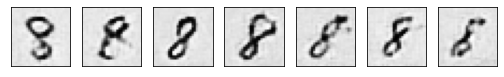

12/12 [==============================] - 4s 336ms/step - d_loss: -9.2816 - g_loss: 5.9888
Epoch 59/100
12/12 [==============================] - ETA: 0s - d_loss: -8.8353 - g_loss: 6.2310epoch 58


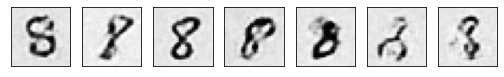

12/12 [==============================] - 4s 334ms/step - d_loss: -8.8148 - g_loss: 6.1917
Epoch 60/100
12/12 [==============================] - ETA: 0s - d_loss: -8.7985 - g_loss: 5.2760epoch 59


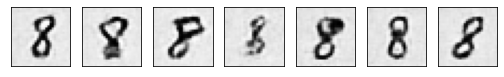

12/12 [==============================] - 4s 337ms/step - d_loss: -8.7842 - g_loss: 5.4269
Epoch 61/100
12/12 [==============================] - ETA: 0s - d_loss: -8.8435 - g_loss: 5.7036epoch 60


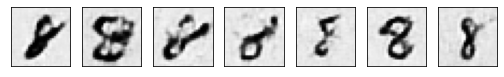

12/12 [==============================] - 4s 367ms/step - d_loss: -8.8440 - g_loss: 5.5826
Epoch 62/100
12/12 [==============================] - ETA: 0s - d_loss: -8.7070 - g_loss: 6.0714epoch 61


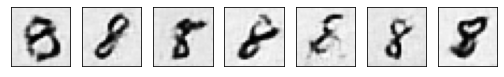

12/12 [==============================] - 4s 337ms/step - d_loss: -8.7242 - g_loss: 6.1600
Epoch 63/100
12/12 [==============================] - ETA: 0s - d_loss: -8.6354 - g_loss: 6.9361epoch 62


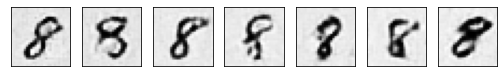

12/12 [==============================] - 4s 337ms/step - d_loss: -8.6782 - g_loss: 6.8943
Epoch 64/100
12/12 [==============================] - ETA: 0s - d_loss: -8.4499 - g_loss: 5.6865epoch 63


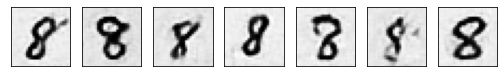

12/12 [==============================] - 4s 336ms/step - d_loss: -8.4518 - g_loss: 5.6873
Epoch 65/100
12/12 [==============================] - ETA: 0s - d_loss: -8.4704 - g_loss: 5.0076epoch 64


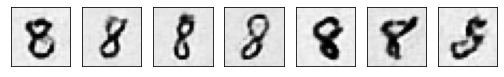

12/12 [==============================] - 4s 338ms/step - d_loss: -8.4605 - g_loss: 5.1945
Epoch 66/100
12/12 [==============================] - ETA: 0s - d_loss: -8.3065 - g_loss: 4.9308epoch 65


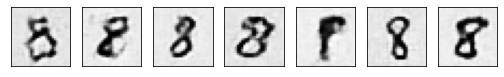

12/12 [==============================] - 4s 340ms/step - d_loss: -8.3220 - g_loss: 4.6613
Epoch 67/100
12/12 [==============================] - ETA: 0s - d_loss: -8.3841 - g_loss: 2.0534epoch 66


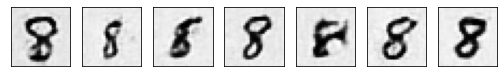

12/12 [==============================] - 4s 335ms/step - d_loss: -8.3548 - g_loss: 1.9691
Epoch 68/100
12/12 [==============================] - ETA: 0s - d_loss: -8.3703 - g_loss: 2.6441epoch 67


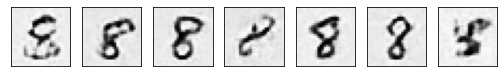

12/12 [==============================] - 4s 335ms/step - d_loss: -8.4052 - g_loss: 2.5139
Epoch 69/100
12/12 [==============================] - ETA: 0s - d_loss: -8.2297 - g_loss: 2.6078epoch 68


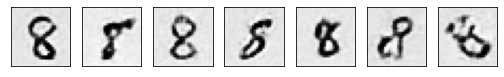

12/12 [==============================] - 4s 337ms/step - d_loss: -8.2283 - g_loss: 2.5999
Epoch 70/100
12/12 [==============================] - ETA: 0s - d_loss: -8.0952 - g_loss: 4.6503epoch 69


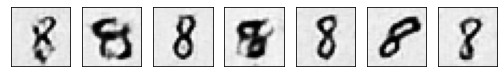

12/12 [==============================] - 4s 338ms/step - d_loss: -8.0583 - g_loss: 4.7756
Epoch 71/100
12/12 [==============================] - ETA: 0s - d_loss: -7.8491 - g_loss: 4.5149epoch 70


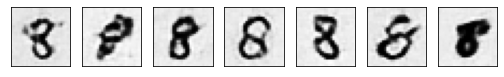

12/12 [==============================] - 4s 337ms/step - d_loss: -7.8456 - g_loss: 4.3638
Epoch 72/100
12/12 [==============================] - ETA: 0s - d_loss: -7.9784 - g_loss: 5.6875epoch 71


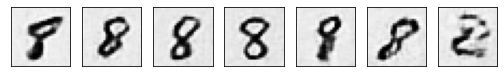

12/12 [==============================] - 4s 367ms/step - d_loss: -7.9823 - g_loss: 5.7377
Epoch 73/100
12/12 [==============================] - ETA: 0s - d_loss: -7.9988 - g_loss: 4.7889epoch 72


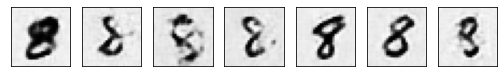

12/12 [==============================] - 4s 340ms/step - d_loss: -8.0421 - g_loss: 4.6229
Epoch 74/100
12/12 [==============================] - ETA: 0s - d_loss: -7.9076 - g_loss: 3.9711epoch 73


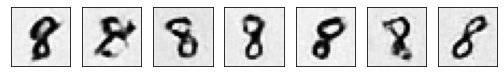

12/12 [==============================] - 4s 338ms/step - d_loss: -7.8573 - g_loss: 3.9000
Epoch 75/100
12/12 [==============================] - ETA: 0s - d_loss: -7.7421 - g_loss: 4.4779epoch 74


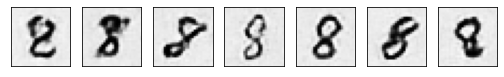

12/12 [==============================] - 4s 338ms/step - d_loss: -7.6980 - g_loss: 4.6033
Epoch 76/100
12/12 [==============================] - ETA: 0s - d_loss: -7.6836 - g_loss: 5.2088epoch 75


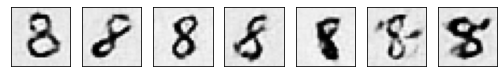

12/12 [==============================] - 4s 336ms/step - d_loss: -7.6644 - g_loss: 5.2798
Epoch 77/100
12/12 [==============================] - ETA: 0s - d_loss: -7.6708 - g_loss: 6.0439epoch 76


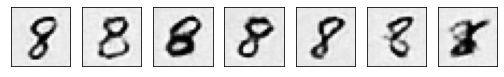

12/12 [==============================] - 4s 338ms/step - d_loss: -7.6887 - g_loss: 6.0164
Epoch 78/100
12/12 [==============================] - ETA: 0s - d_loss: -7.5926 - g_loss: 4.5602epoch 77


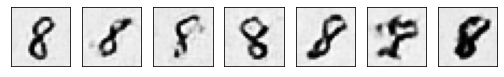

12/12 [==============================] - 4s 336ms/step - d_loss: -7.5741 - g_loss: 4.5718
Epoch 79/100
12/12 [==============================] - ETA: 0s - d_loss: -7.3631 - g_loss: 3.7535epoch 78


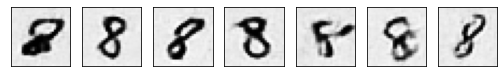

12/12 [==============================] - 4s 337ms/step - d_loss: -7.3718 - g_loss: 3.8226
Epoch 80/100
12/12 [==============================] - ETA: 0s - d_loss: -7.4370 - g_loss: 3.6215epoch 79


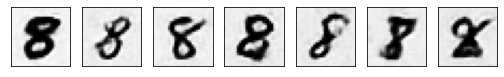

12/12 [==============================] - 4s 336ms/step - d_loss: -7.4185 - g_loss: 3.6652
Epoch 81/100
12/12 [==============================] - ETA: 0s - d_loss: -7.1885 - g_loss: 5.0223epoch 80


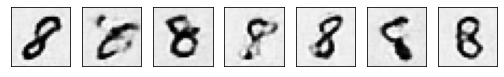

12/12 [==============================] - 4s 337ms/step - d_loss: -7.2112 - g_loss: 5.0219
Epoch 82/100
12/12 [==============================] - ETA: 0s - d_loss: -7.2548 - g_loss: 5.1373epoch 81


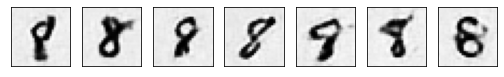

12/12 [==============================] - 4s 337ms/step - d_loss: -7.2642 - g_loss: 5.0811
Epoch 83/100
12/12 [==============================] - ETA: 0s - d_loss: -7.0675 - g_loss: 7.0327epoch 82


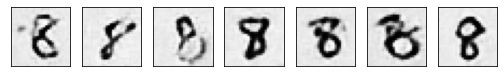

12/12 [==============================] - 4s 368ms/step - d_loss: -7.0349 - g_loss: 7.2104
Epoch 84/100
12/12 [==============================] - ETA: 0s - d_loss: -7.1330 - g_loss: 8.9875epoch 83


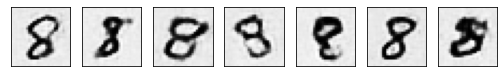

12/12 [==============================] - 4s 338ms/step - d_loss: -7.1263 - g_loss: 8.9906
Epoch 85/100
12/12 [==============================] - ETA: 0s - d_loss: -7.0432 - g_loss: 9.6011epoch 84


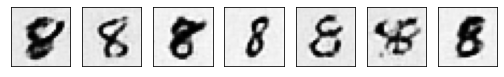

12/12 [==============================] - 4s 338ms/step - d_loss: -7.0354 - g_loss: 9.4703
Epoch 86/100
12/12 [==============================] - ETA: 0s - d_loss: -7.2388 - g_loss: 9.0940epoch 85


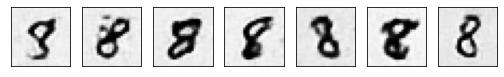

12/12 [==============================] - 4s 336ms/step - d_loss: -7.2549 - g_loss: 9.2120
Epoch 87/100
12/12 [==============================] - ETA: 0s - d_loss: -6.9799 - g_loss: 9.2720epoch 86


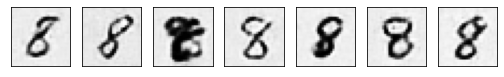

12/12 [==============================] - 4s 336ms/step - d_loss: -6.9766 - g_loss: 9.2052
Epoch 88/100
12/12 [==============================] - ETA: 0s - d_loss: -6.7762 - g_loss: 7.3405epoch 87


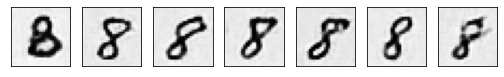

12/12 [==============================] - 4s 336ms/step - d_loss: -6.7783 - g_loss: 7.2135
Epoch 89/100
12/12 [==============================] - ETA: 0s - d_loss: -6.7604 - g_loss: 7.1208epoch 88


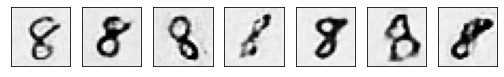

12/12 [==============================] - 4s 337ms/step - d_loss: -6.7077 - g_loss: 7.1548
Epoch 90/100
12/12 [==============================] - ETA: 0s - d_loss: -6.9576 - g_loss: 6.9663epoch 89


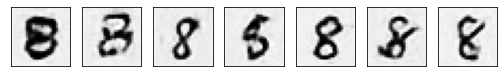

12/12 [==============================] - 4s 336ms/step - d_loss: -6.9362 - g_loss: 6.9889
Epoch 91/100
12/12 [==============================] - ETA: 0s - d_loss: -6.6608 - g_loss: 7.7201epoch 90


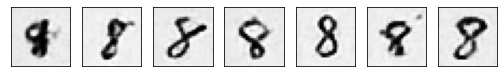

12/12 [==============================] - 4s 338ms/step - d_loss: -6.6555 - g_loss: 7.6130
Epoch 92/100
12/12 [==============================] - ETA: 0s - d_loss: -6.6103 - g_loss: 9.5212epoch 91


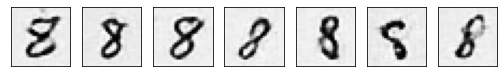

12/12 [==============================] - 4s 343ms/step - d_loss: -6.6294 - g_loss: 9.5491
Epoch 93/100
12/12 [==============================] - ETA: 0s - d_loss: -6.6543 - g_loss: 9.6300epoch 92


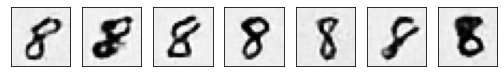

12/12 [==============================] - 4s 338ms/step - d_loss: -6.6612 - g_loss: 9.6537
Epoch 94/100
12/12 [==============================] - ETA: 0s - d_loss: -6.5762 - g_loss: 9.4323epoch 93


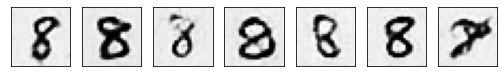

12/12 [==============================] - 4s 367ms/step - d_loss: -6.5433 - g_loss: 9.4684
Epoch 95/100
12/12 [==============================] - ETA: 0s - d_loss: -6.4305 - g_loss: 9.3916epoch 94


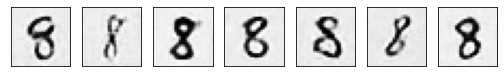

12/12 [==============================] - 4s 339ms/step - d_loss: -6.4147 - g_loss: 9.3057
Epoch 96/100
12/12 [==============================] - ETA: 0s - d_loss: -6.4361 - g_loss: 8.1490epoch 95


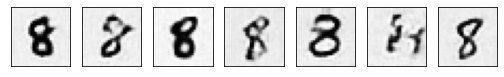

12/12 [==============================] - 4s 341ms/step - d_loss: -6.4709 - g_loss: 7.9221
Epoch 97/100
12/12 [==============================] - ETA: 0s - d_loss: -6.2959 - g_loss: 8.4043epoch 96


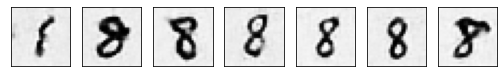

12/12 [==============================] - 4s 337ms/step - d_loss: -6.2641 - g_loss: 8.3082
Epoch 98/100
12/12 [==============================] - ETA: 0s - d_loss: -6.3316 - g_loss: 8.1191epoch 97


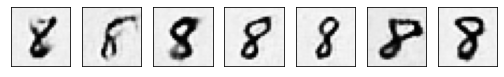

12/12 [==============================] - 4s 336ms/step - d_loss: -6.2917 - g_loss: 8.1868
Epoch 99/100
12/12 [==============================] - ETA: 0s - d_loss: -6.2745 - g_loss: 8.5680epoch 98


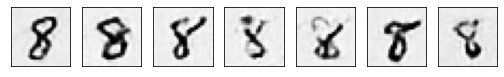

12/12 [==============================] - 4s 338ms/step - d_loss: -6.2770 - g_loss: 8.4923
Epoch 100/100
12/12 [==============================] - ETA: 0s - d_loss: -6.0802 - g_loss: 8.1572epoch 99


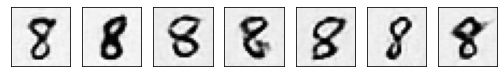

12/12 [==============================] - 4s 338ms/step - d_loss: -6.0373 - g_loss: 8.1388


In [ ]:
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

cbk = GANMonitor(num_img=8, latent_dim=noise_dim)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=100, callbacks=[cbk])

Display the last generated images:


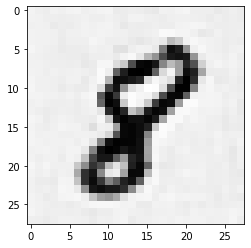

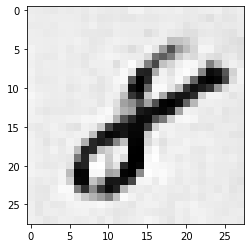

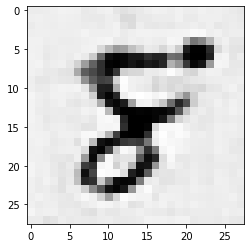

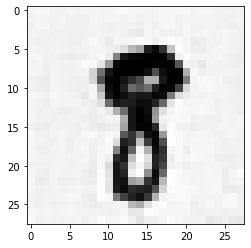

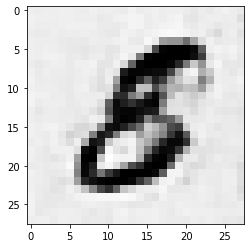

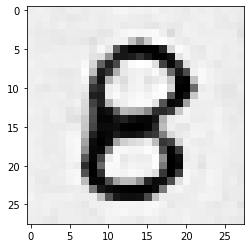

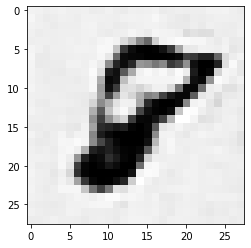

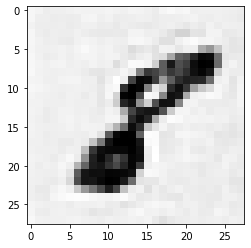

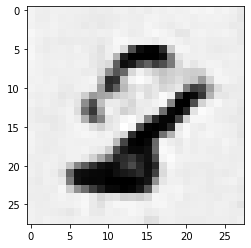

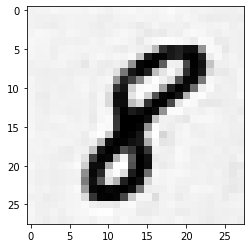

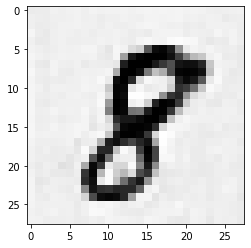

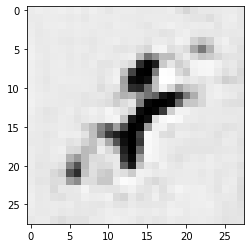

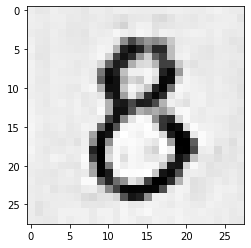

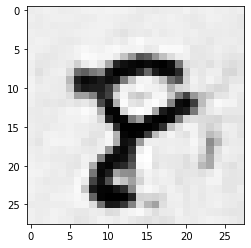

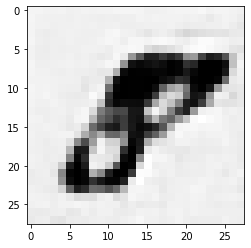

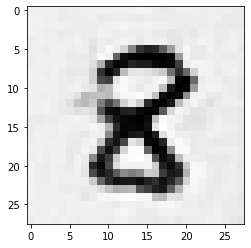

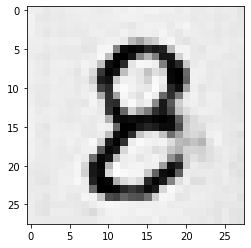

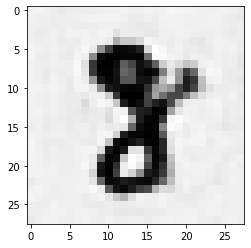

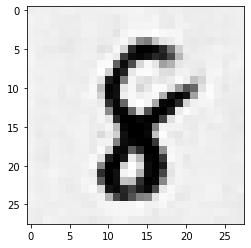

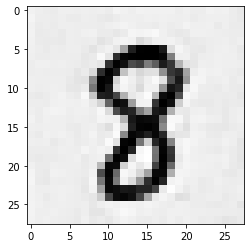

In [ ]:
import matplotlib.pyplot as plt

random_latent_vectors = tf.random.normal(shape=(20, noise_dim))

generated_images = wgan.generator(random_latent_vectors)
generated_images = (generated_images * 127.5) + 127.5
for image in generated_images:
  plt.imshow(image.numpy().squeeze(), cmap="binary")
  plt.show()

[-0.05005956]


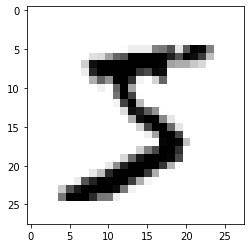

[0.47011113]


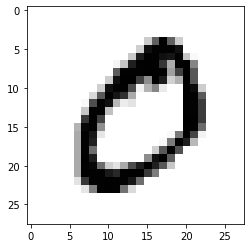

[1.0891695]


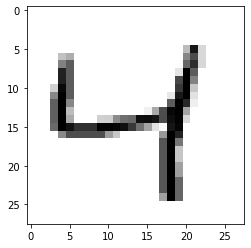

[0.8067279]


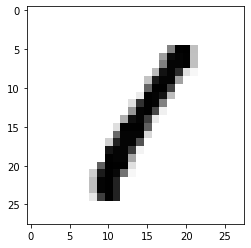

[0.07749987]


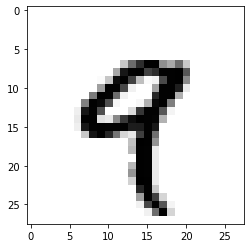

[0.14925289]


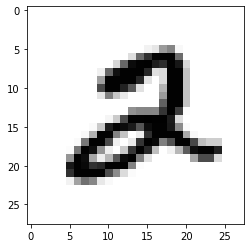

[0.4927621]


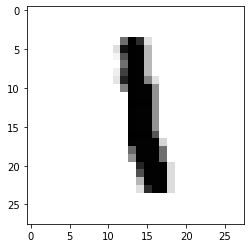

[-1.0002577]


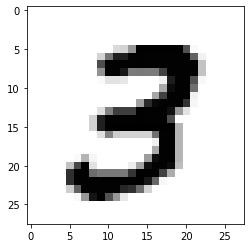

[1.0042446]


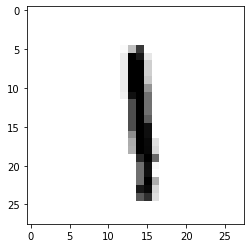

[-0.01324368]


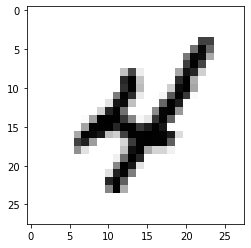

[-0.37402964]


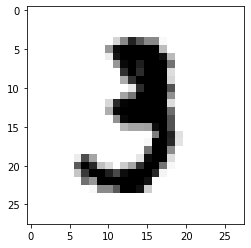

[1.9485416]


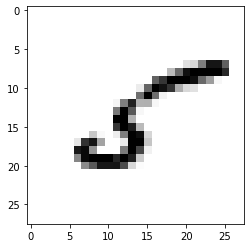

[-2.3341832]


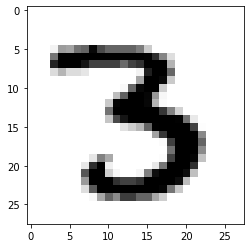

[-0.45486903]


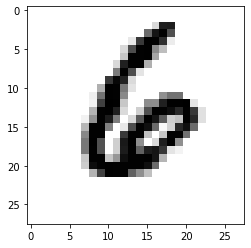

[0.9105239]


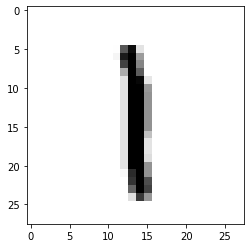

[0.1007967]


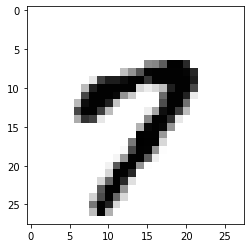

In [ ]:
predictions = wgan.discriminator(images[:16]).numpy()
for i in range(len(predictions)):
    print(predictions[i])
    plt.imshow(images[i].squeeze(), cmap="binary")
    plt.show()

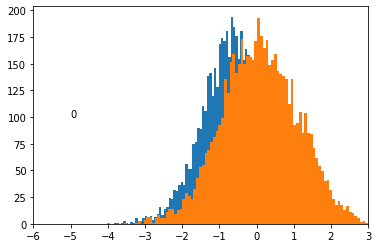

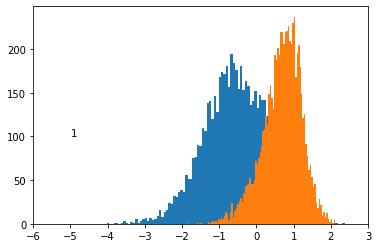

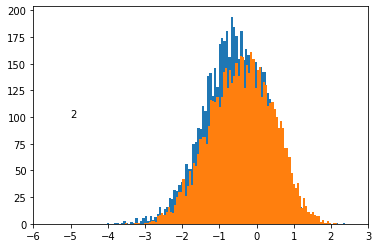

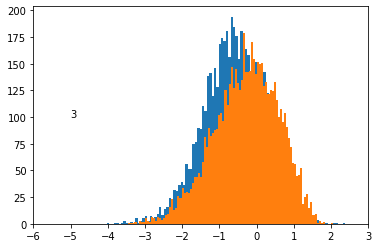

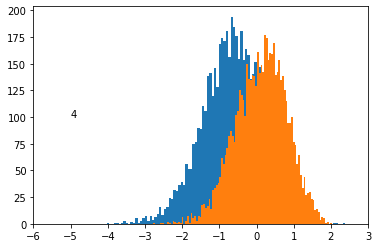

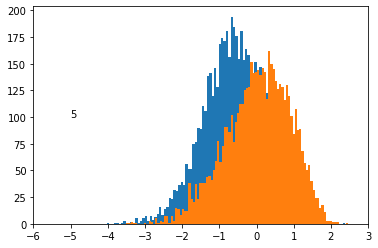

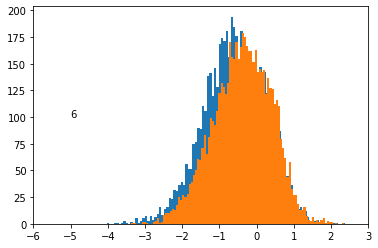

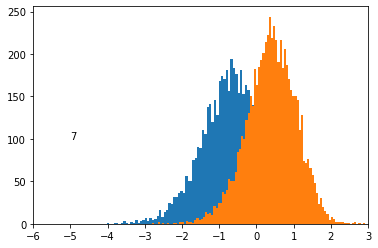

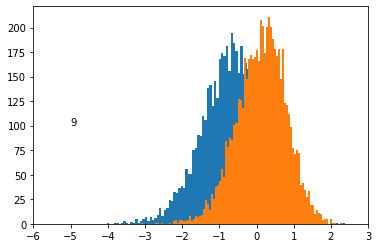

In [ ]:
normal_images = images[np.where(raw_train_y==NORMAL_NUMMBER)]
normal_predictions = wgan.discriminator(normal_images).numpy()

for target_number in range(10):
    if target_number==NORMAL_NUMMBER: continue
    indexes = np.where(raw_train_y==target_number)
    target_images = images[indexes]
    predictions = wgan.discriminator(target_images).numpy()
    plt.hist(normal_predictions.flatten(), bins=100)
    plt.hist(predictions.flatten(), bins=100)
    plt.xlim([-6, 3])
    plt.text(-5, 100, str(target_number))
    plt.show()